In [1]:
import helicity_model_1d
# %env PYTORCH_ENABLE_MPS_FALLBACK=1
%load_ext autoreload
%autoreload

from bins import Bins
from eventsreader import Frame
from hist_utils import HistMaker, HistMaker1d, geom_avg1d, symmetrize
from hist_template import set_opt_text, set_th1, set_pad
import helicity_model_1d
import helicity_model_3d
from plotting import plot_losses, show_results, paveTexts
from ROOT import TH1, TF1, TCanvas, gStyle, TLegend
import calendar, os
from time import time, gmtime

Welcome to JupyROOT 6.28/04


In [2]:
gStyle.SetOptStat(0)

analyse_3d = True
learn_norm = False
same_sign_symm = False
ag1580ag = True
event_mixing = False
symmetrize_explicit = False
read_saved = False
range_used = range(0,12)
fraction = 0.8

if read_saved:
    if event_mixing:
        if ag1580ag:
            DIR_NAME = "results_mixing_nu15_noise1em1_1d_ag1580ag"
        else:
            DIR_NAME = "results_mixing_nu15_noise1em1_1d"
    else:
        if ag1580ag:
           # DIR_NAME = "results_sameevt_nu15_noise1em1_1d_ag1580ag_noconstr"
           # DIR_NAME = "results_helip1cm_nu15_noise1em1_1d_ag1580ag_noconstr"
           # DIR_NAME = "results_helip1cm_nu15_noise1em1_1d_ag1580ag_noconstr_vertexsim_epem"
            DIR_NAME = "results_1702372287"
        else:
            DIR_NAME = "results_sameevt_nu15_noise1em1_1d"
else:
    current_GMT =   gmtime()
    time_stamp = calendar.timegm(current_GMT)
    DIR_NAME = f'results_{time_stamp}'
    os.mkdir(DIR_NAME)

In [3]:
if ag1580ag:
    ekin = 1580
    filename_data_np = "063_088_ag158ag_3200A_accepted_np.dat"
   # filename_data_np = "mar19_diele_inmedium_helip1cm_ag1580ag_np.dat"
   # filename_data_np = "mar19_diele_inmedium_helip1cm_ag1580ag_jver22_np.dat"
    filename_data_pp = "063_088_ag158ag_3200A_accepted_pp.dat"
    filename_data_nn = "063_088_ag158ag_3200A_accepted_nn.dat"
    filename_data_np_mix = "063_088_ag158ag_3200A_accepted_np_mix_hc.dat"
    filename_data_pp_mix = "apr12_diele_086_ag158ag_3200A_accepted_1_pp_mix_hc.dat"
    filename_data_nn_mix = "apr12_diele_086_ag158ag_3200A_accepted_1_nn_mix_hc.dat"
    filename_MC_rho_4pi_heli0 = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_2_np_kine.dat"
    filename_MC_rho_4pi_heli1 = "mar19_diele_inmedium_helip1cm_ag1580ag_jver22_2_np_kine.dat"
   # filename_MC_rho_heli0_np = "mar19_diele_inmedium_heli0cm_ag1580ag_np.dat"
   # filename_MC_rho_heli0_np = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_np.dat"
   # filename_MC_rho_heli0_pp = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_pp.dat"
   # filename_MC_rho_heli0_nn = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_nn.dat"
    filename_MC_rho_heli0_np = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_np_newCuts.dat"
    filename_MC_rho_heli0_pp = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_pp_newCuts.dat"
    filename_MC_rho_heli0_nn = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_nn_newCuts.dat"
    filename_MC_rho_heli1 = "mar19_diele_inmedium_helip1cm_ag1580ag_jver22_np.dat"
    filename_MC_pi0 = "mar19_diele_pi0_heli0cm_ag1580ag_jver22_np.dat"
    filename_MC_mix = "mar19_diele_pi0_heli0cm_ag1580ag_np_mix.dat"
    if same_sign_symm:
        filename_data_pp = "063_088_ag158ag_3200A_accepted_pp_symm.dat"
        filename_data_nn = "063_088_ag158ag_3200A_accepted_nn_symm.dat"
        filename_data_pp_mix = "apr12_diele_086_ag158ag_3200A_accepted_1_pp_mix_hc_symm.dat"
        filename_data_nn_mix = "apr12_diele_086_ag158ag_3200A_accepted_1_nn_mix_hc_symm.dat"
        filename_MC_rho_heli0_pp = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_pp_swapRandomly.dat"
        filename_MC_rho_heli0_nn = "mar19_diele_inmedium_heli0cm_ag1580ag_jver22_nn_swapRandomly.dat"
else:
    ekin = 1230
    filename_data_np = "apr12_diele_088_090_ag123ag_2500A_accepted_np_2.dat"
    filename_data_pp = "088_090_ag123ag_2500A_accepted_pp.dat"
    filename_data_nn = "088_090_ag123ag_2500A_accepted_nn.dat"
    filename_data_np_mix = "apr12_diele_089_ag123ag_2500A_accepted_93_np_mix_hc.dat"
    filename_data_pp_mix = "088_090_ag123ag_2500A_accepted_pp_mix_hc.dat"
    filename_data_nn_mix = "088_090_ag123ag_2500A_accepted_nn_mix_hc.dat"
    filename_MC_rho_heli0_np = "mar19_diele_inmedium_heli0cm_ag1230ag_jver22_np.dat"
    filename_MC_rho_heli0_pp = "mar19_diele_inmedium_heli0cm_ag1230ag_jver22_pp.dat"
    filename_MC_rho_heli0_nn = "mar19_diele_inmedium_heli0cm_ag1230ag_jver22_nn.dat"
    filename_MC_rho_heli1 = "mar19_diele_inmedium_helip1cm_ag1580ag_jver22_np.dat"
    filename_MC_pi0 = "mar19_diele_pi0_heli0cm_ag1580ag_np.dat"
    filename_MC_mix = "mar19_diele_pi0_heli0cm_np_mix.dat"


frame = Frame.HX

HistMakerClass = HistMaker if analyse_3d else HistMaker1d

bins = Bins.readFrom("ranges.yml")
#histMakerData_np = HistMakerClass("apr12_diele_088_090_ag123ag_2500A_accepted_np_mix_hc_sample_2.dat", "_data", bins, frame)
if event_mixing:
    histMakerData_np = HistMakerClass(filename_data_np_mix, "_data_np", bins, frame, ekin)
else:
    histMakerData_np = HistMakerClass(filename_data_np, "_data_np", bins, frame, ekin)
histsData_np = histMakerData_np.make_hists  ()
histMakerData_pp = HistMakerClass(filename_data_pp, "_data_pp", bins, frame, ekin)
histsData_pp = histMakerData_pp.make_hists()
histMakerData_nn = HistMakerClass(filename_data_nn, "_data_nn", bins, frame, ekin)
histsData_nn = histMakerData_nn.make_hists()

histMakerData_np_mix = HistMakerClass(filename_data_np_mix, "_data_np_mix", bins, frame, ekin)
histsData_np_mix = histMakerData_np_mix.make_hists()
histMakerData_pp_mix = HistMakerClass(filename_data_np_mix, "_data_pp_mix", bins, frame, ekin)
histsData_pp_mix = histMakerData_pp_mix.make_hists()
histMakerData_nn_mix = HistMakerClass(filename_data_nn_mix, "_data_nn_mix", bins, frame, ekin)
histsData_nn_mix = histMakerData_nn_mix.make_hists()

histMakerMC_rho_heli0 = HistMakerClass(filename_MC_rho_heli0_np, "_MC_rho_heli0", bins, frame, ekin)
histMakerMC_rho_heli0_pp = HistMakerClass(filename_MC_rho_heli0_pp, "_MC_rho_heli0_pp", bins, frame, ekin)
histMakerMC_rho_heli0_nn = HistMakerClass(filename_MC_rho_heli0_nn, "_MC_rho_heli0_nn", bins, frame, ekin)
histMakerMC_rho_heli1 = HistMakerClass(filename_MC_rho_heli1, "_MC_rho_heli1", bins, frame, ekin)
histMakerMC_pi0 = HistMakerClass(filename_MC_pi0, "_MC_pi0", bins, frame, ekin)
histMakerMC_mix = HistMakerClass(filename_MC_mix, "_MC_mix", bins, frame, ekin)
#histMakerMC_mix = HistMakerClass("test_inmedium_heli0cm_np_mix.dat", "_MC_rho_mix", bins, frame)
#histMakerMC_mix = HistMakerClass("mar19_diele_pi0_heli0cm_np_mix.dat", "_MC_rho_mix", bins, frame)
def get_hist_maker_mc(sign, hist_index):
    if event_mixing:
        return histMakerMC_mix
    else:
        if hist_index < 3:
            return histMakerMC_pi0 
        else:
            if sign == "np":
                return histMakerMC_rho_heli0
            elif sign == "pp":
                return histMakerMC_rho_heli0_pp
            else:
                return histMakerMC_rho_heli0_nn
        # return histMakerMC_rho_heli0

Pickle file exists
iter 0
Before processing events 15:49:57
After processing events 15:49:58
Pickle file exists
iter 1
Before processing events 15:49:58
After processing events 15:49:58
Pickle file exists
iter 2
Before processing events 15:49:59
After processing events 15:49:59
Pickle file exists
iter 3
Before processing events 15:50:05
After processing events 15:50:07
Pickle file exists
iter 4
Before processing events 15:50:14
After processing events 15:50:16
Pickle file exists
iter 5
Before processing events 15:50:25
After processing events 15:50:29
Pickle file exists
iter 6
Before processing events 15:50:34
After processing events 15:50:36
Pickle file exists
iter 7
Before processing events 15:50:44
After processing events 15:50:45
Pickle file exists
iter 8
Before processing events 15:50:58
After processing events 15:50:59
Pickle file exists
iter 9
Before processing events 15:51:02
After processing events 15:51:05
Pickle file exists
iter 10
Before processing events 15:51:20
After pro

In [4]:
import torch

torch.device("mps")
torch.manual_seed(0)

import gpytorch
import botorch

import matplotlib.pyplot as plt

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (8, 6)

from tqdm.notebook import tqdm

import warnings

In [5]:
TH1.SetDefaultSumw2()

gpytorch.settings.fast_pred_var()
gpytorch.settings.fast_pred_samples()

N_PARAMS = 1

In [6]:
torch.backends.mps.is_available()
#mps_device = torch.device("mps")
mps_device = torch.device("cpu")
bounds = torch.tensor([[-2, ],
                       [ 2, ]], dtype=torch.float)
bounds = bounds.to(mps_device)


xs = torch.linspace(bounds[0][0], bounds[1][0], 101)

In [7]:
parameters_all_np = []
losses_all_np = [[]]* len(range_used)

fit_simple = helicity_model_3d.fit_simple if analyse_3d else helicity_model_1d.fit_simple

for HIST_INDEX in range_used:
    simple_model = helicity_model_3d.Helicity3d(learn_norm) if analyse_3d else helicity_model_1d.Helicity1d(learn_norm)
    hist_data_simple = histsData_np[0][HIST_INDEX]
    hist_mc_simple = get_hist_maker_mc("np", HIST_INDEX).make_hists(0.0)[0][HIST_INDEX]
    if HIST_INDEX == 2:
        losses = fit_simple(simple_model, hist_data_simple, hist_mc_simple, 1000, 0.01, learn_norm)
    else:
        losses = fit_simple(simple_model, hist_data_simple, hist_mc_simple, 1000, 0.01, learn_norm)
    parameters_all_np.append([param for param in simple_model.parameters()])
    losses_all_np[HIST_INDEX] = losses
    
parameters_all_pp = []
losses_all_pp = [[]]* len(range_used)

for HIST_INDEX in range_used:
    simple_model = helicity_model_3d.Helicity3d(learn_norm) if analyse_3d else helicity_model_1d.Helicity1d(learn_norm)
    hist_data_simple = histsData_pp[0][HIST_INDEX]
    hist_mc_simple = get_hist_maker_mc("pp", HIST_INDEX).make_hists(0.0)[0][HIST_INDEX]
    losses = fit_simple(simple_model, hist_data_simple, hist_mc_simple, 5000, 0.02, learn_norm)
    parameters_all_pp.append([param for param in simple_model.parameters()])
    losses_all_pp[HIST_INDEX] = losses
    
parameters_all_nn = []
losses_all_nn = [[]]* len(range_used)

for HIST_INDEX in range_used:
    simple_model = helicity_model_3d.Helicity3d(learn_norm) if analyse_3d else helicity_model_1d.Helicity1d(learn_norm)
    hist_data_simple = histsData_nn[0][HIST_INDEX]
    hist_mc_simple = get_hist_maker_mc("nn", HIST_INDEX).make_hists(0.0)[0][HIST_INDEX]
    losses = fit_simple(simple_model, hist_data_simple, hist_mc_simple, 5000, 0.02, learn_norm)
    parameters_all_nn.append([param for param in simple_model.parameters()])
    losses_all_nn[HIST_INDEX] = losses

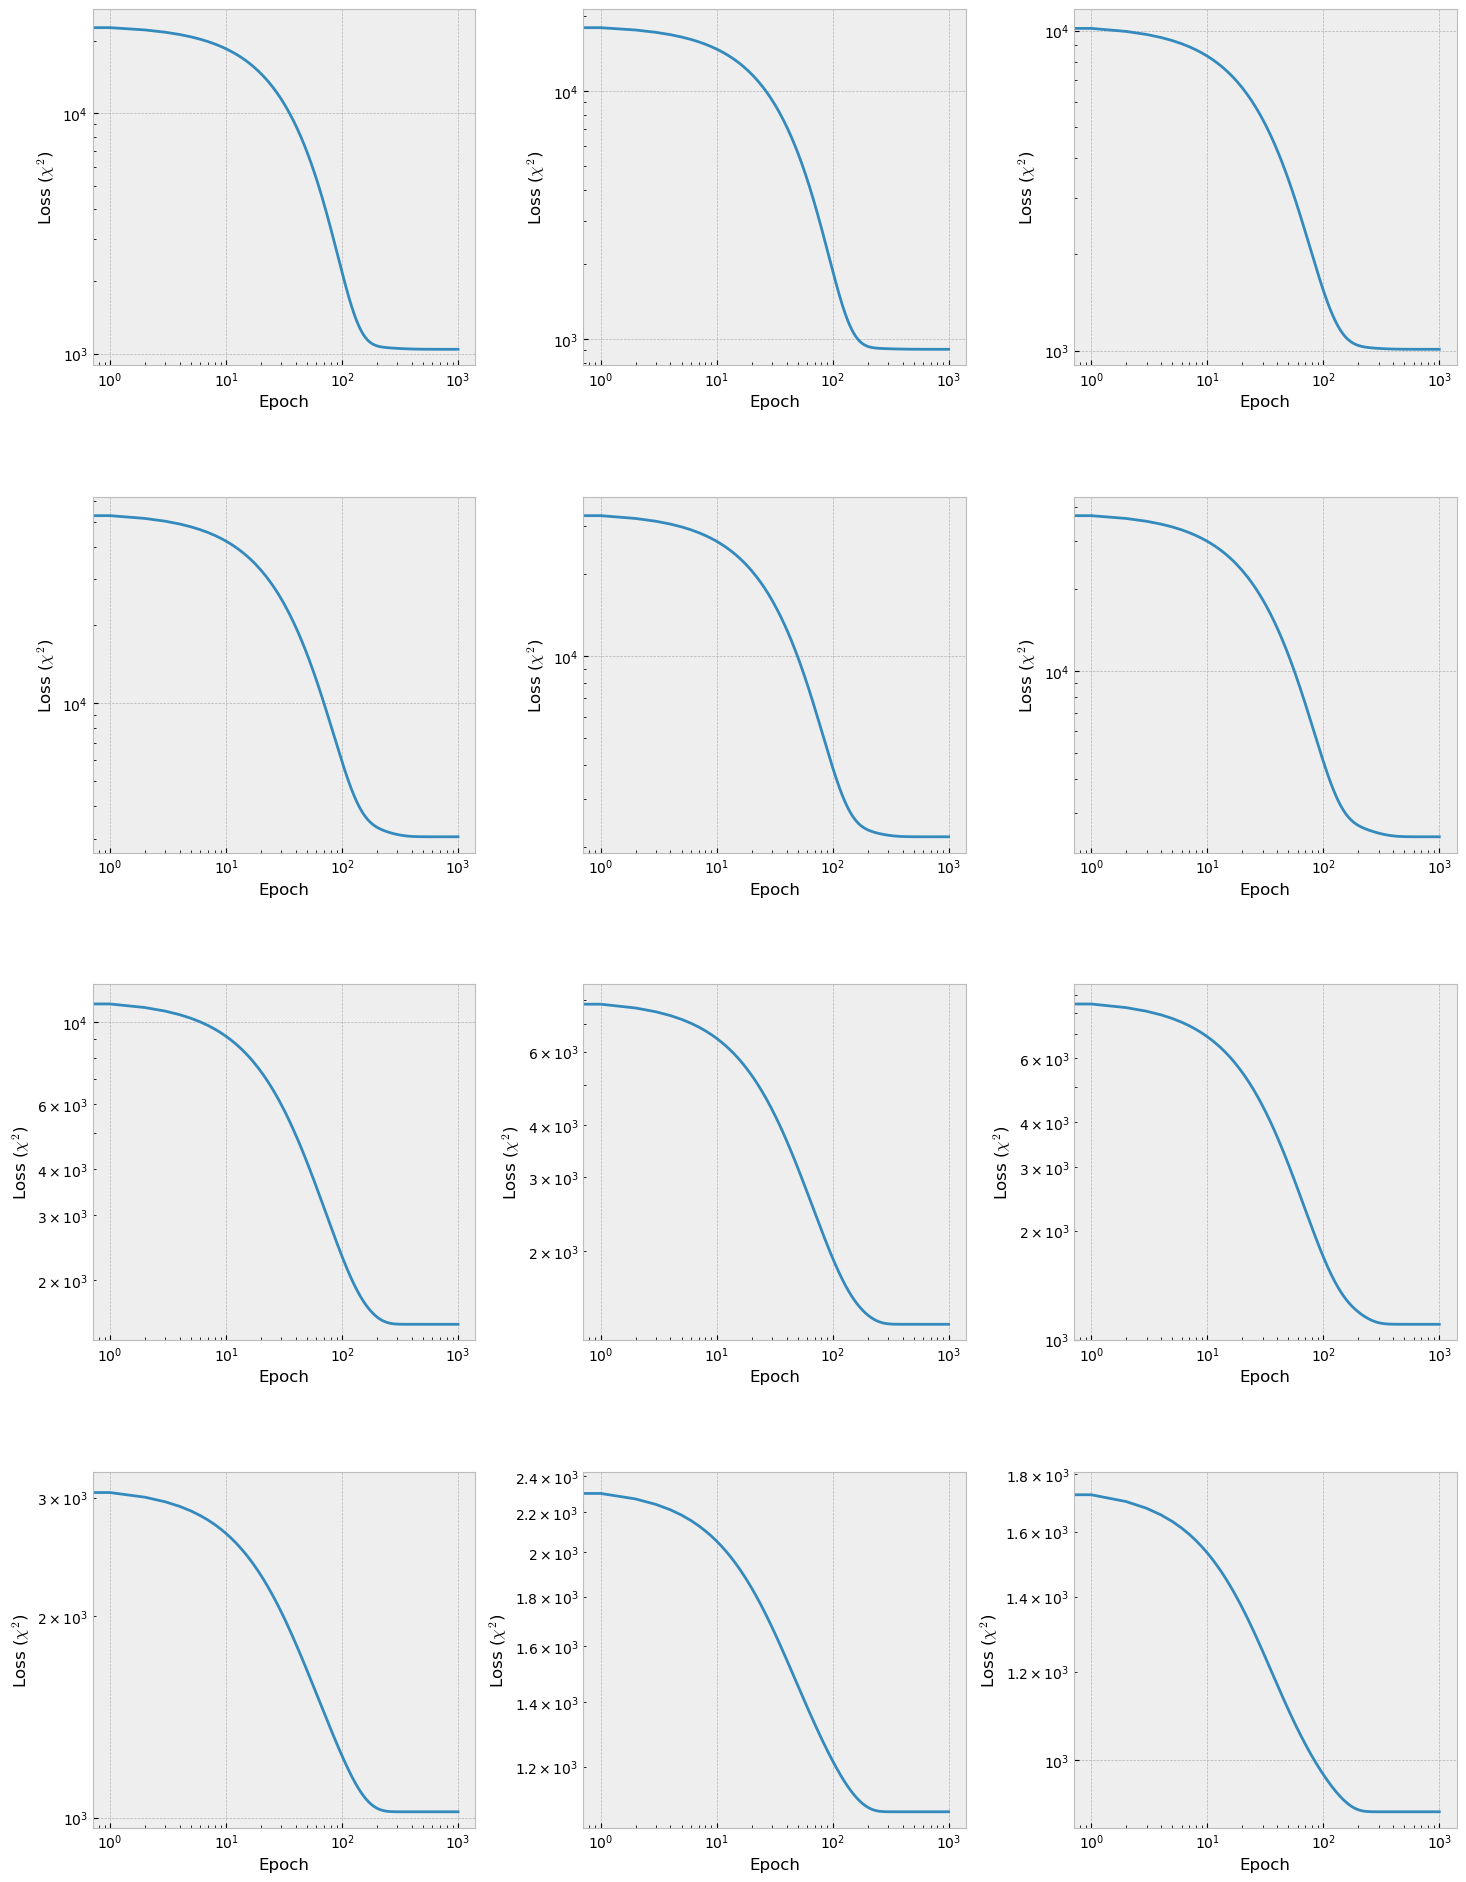

In [8]:
fig_np, ax_np = plot_losses(losses_all_np, range_used)

0. Final result: lambda_theta =  1.1557869911193848  +-  nan
1. Final result: lambda_theta =  1.3360142707824707  +-  nan
2. Final result: lambda_theta =  1.1212334632873535  +-  nan
3. Final result: lambda_theta =  0.9853947758674622  +-  nan
4. Final result: lambda_theta =  1.0359917879104614  +-  nan
5. Final result: lambda_theta =  0.9062156081199646  +-  nan
6. Final result: lambda_theta =  0.6719279289245605  +-  nan
7. Final result: lambda_theta =  0.6359719634056091  +-  nan
8. Final result: lambda_theta =  0.6964612007141113  +-  nan
9. Final result: lambda_theta =  0.5223339796066284  +-  nan
10. Final result: lambda_theta =  0.4393695294857025  +-  nan
11. Final result: lambda_theta =  0.4579690396785736  +-  nan


Error in <TH2F::GetBinCenter>: Invalid method for a 2-d histogram - return a NaN
Error in <TH2F::GetBinCenter>: Invalid method for a 2-d histogram - return a NaN
Error in <TH2F::GetBinCenter>: Invalid method for a 2-d histogram - return a NaN
Error in <TH2F::GetBinCenter>: Invalid method for a 2-d histogram - return a NaN
Error in <TH2F::GetBinCenter>: Invalid method for a 2-d histogram - return a NaN
Error in <TH2F::GetBinCenter>: Invalid method for a 2-d histogram - return a NaN
Error in <TH2F::GetBinCenter>: Invalid method for a 2-d histogram - return a NaN
Error in <TH2F::GetBinCenter>: Invalid method for a 2-d histogram - return a NaN
Error in <TH2F::GetBinCenter>: Invalid method for a 2-d histogram - return a NaN
Error in <TH2F::GetBinCenter>: Invalid method for a 2-d histogram - return a NaN
Error in <TH2F::GetBinCenter>: Invalid method for a 2-d histogram - return a NaN
Error in <TH2F::GetBinCenter>: Invalid method for a 2-d histogram - return a NaN
Error in <TH2F::GetBinCenter

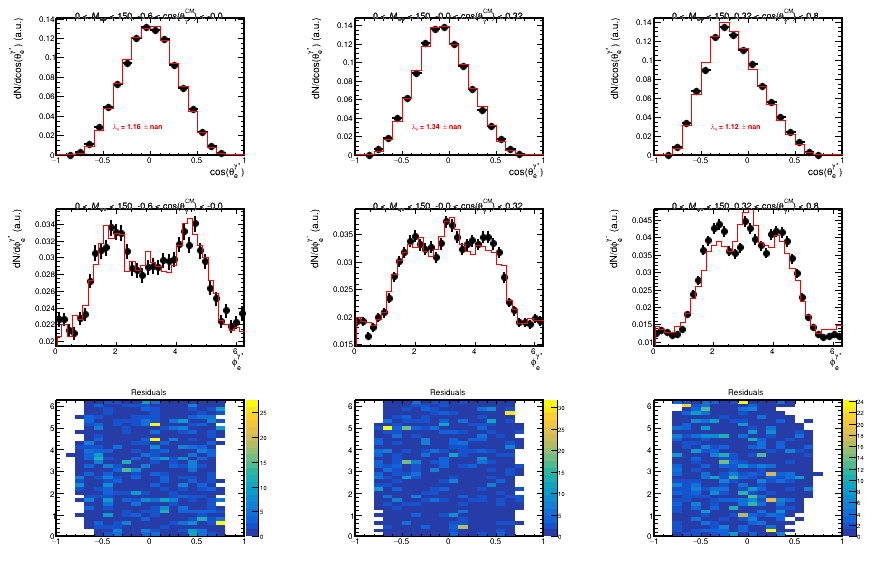

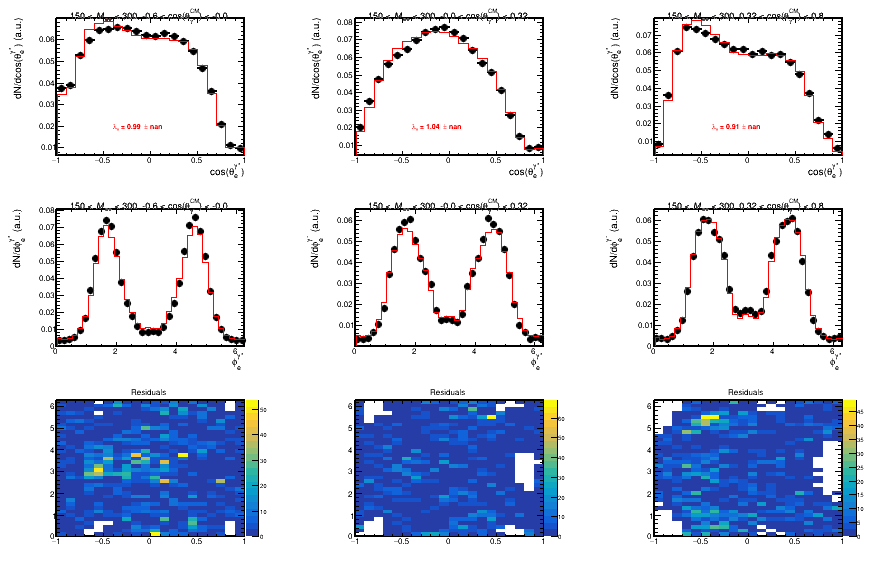

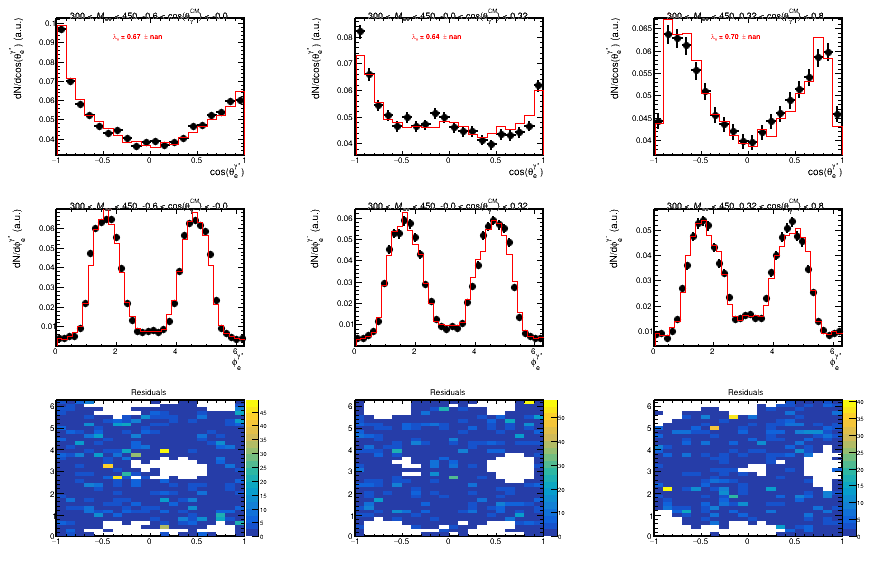

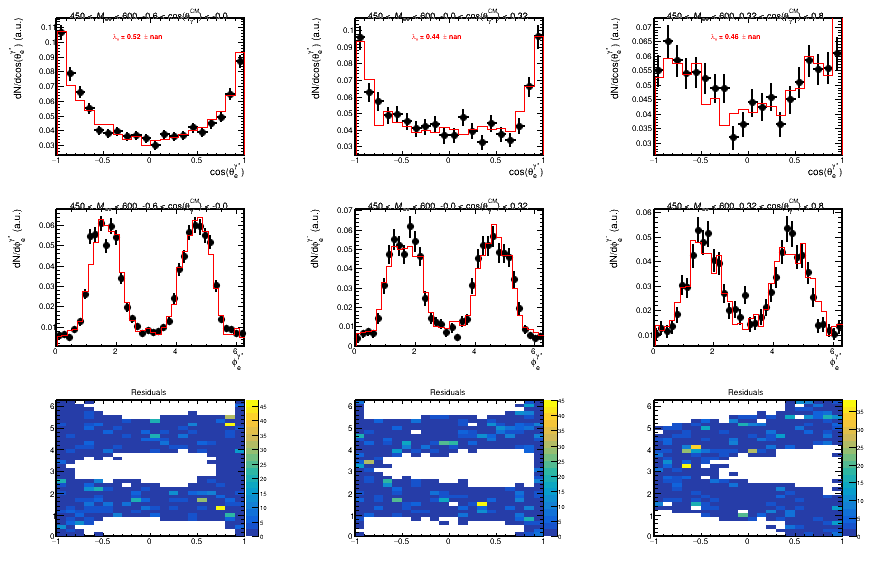

In [9]:
show_results("np", DIR_NAME, range_used, parameters_all_np, get_hist_maker_mc, bins, histsData_np, analyse_3d)

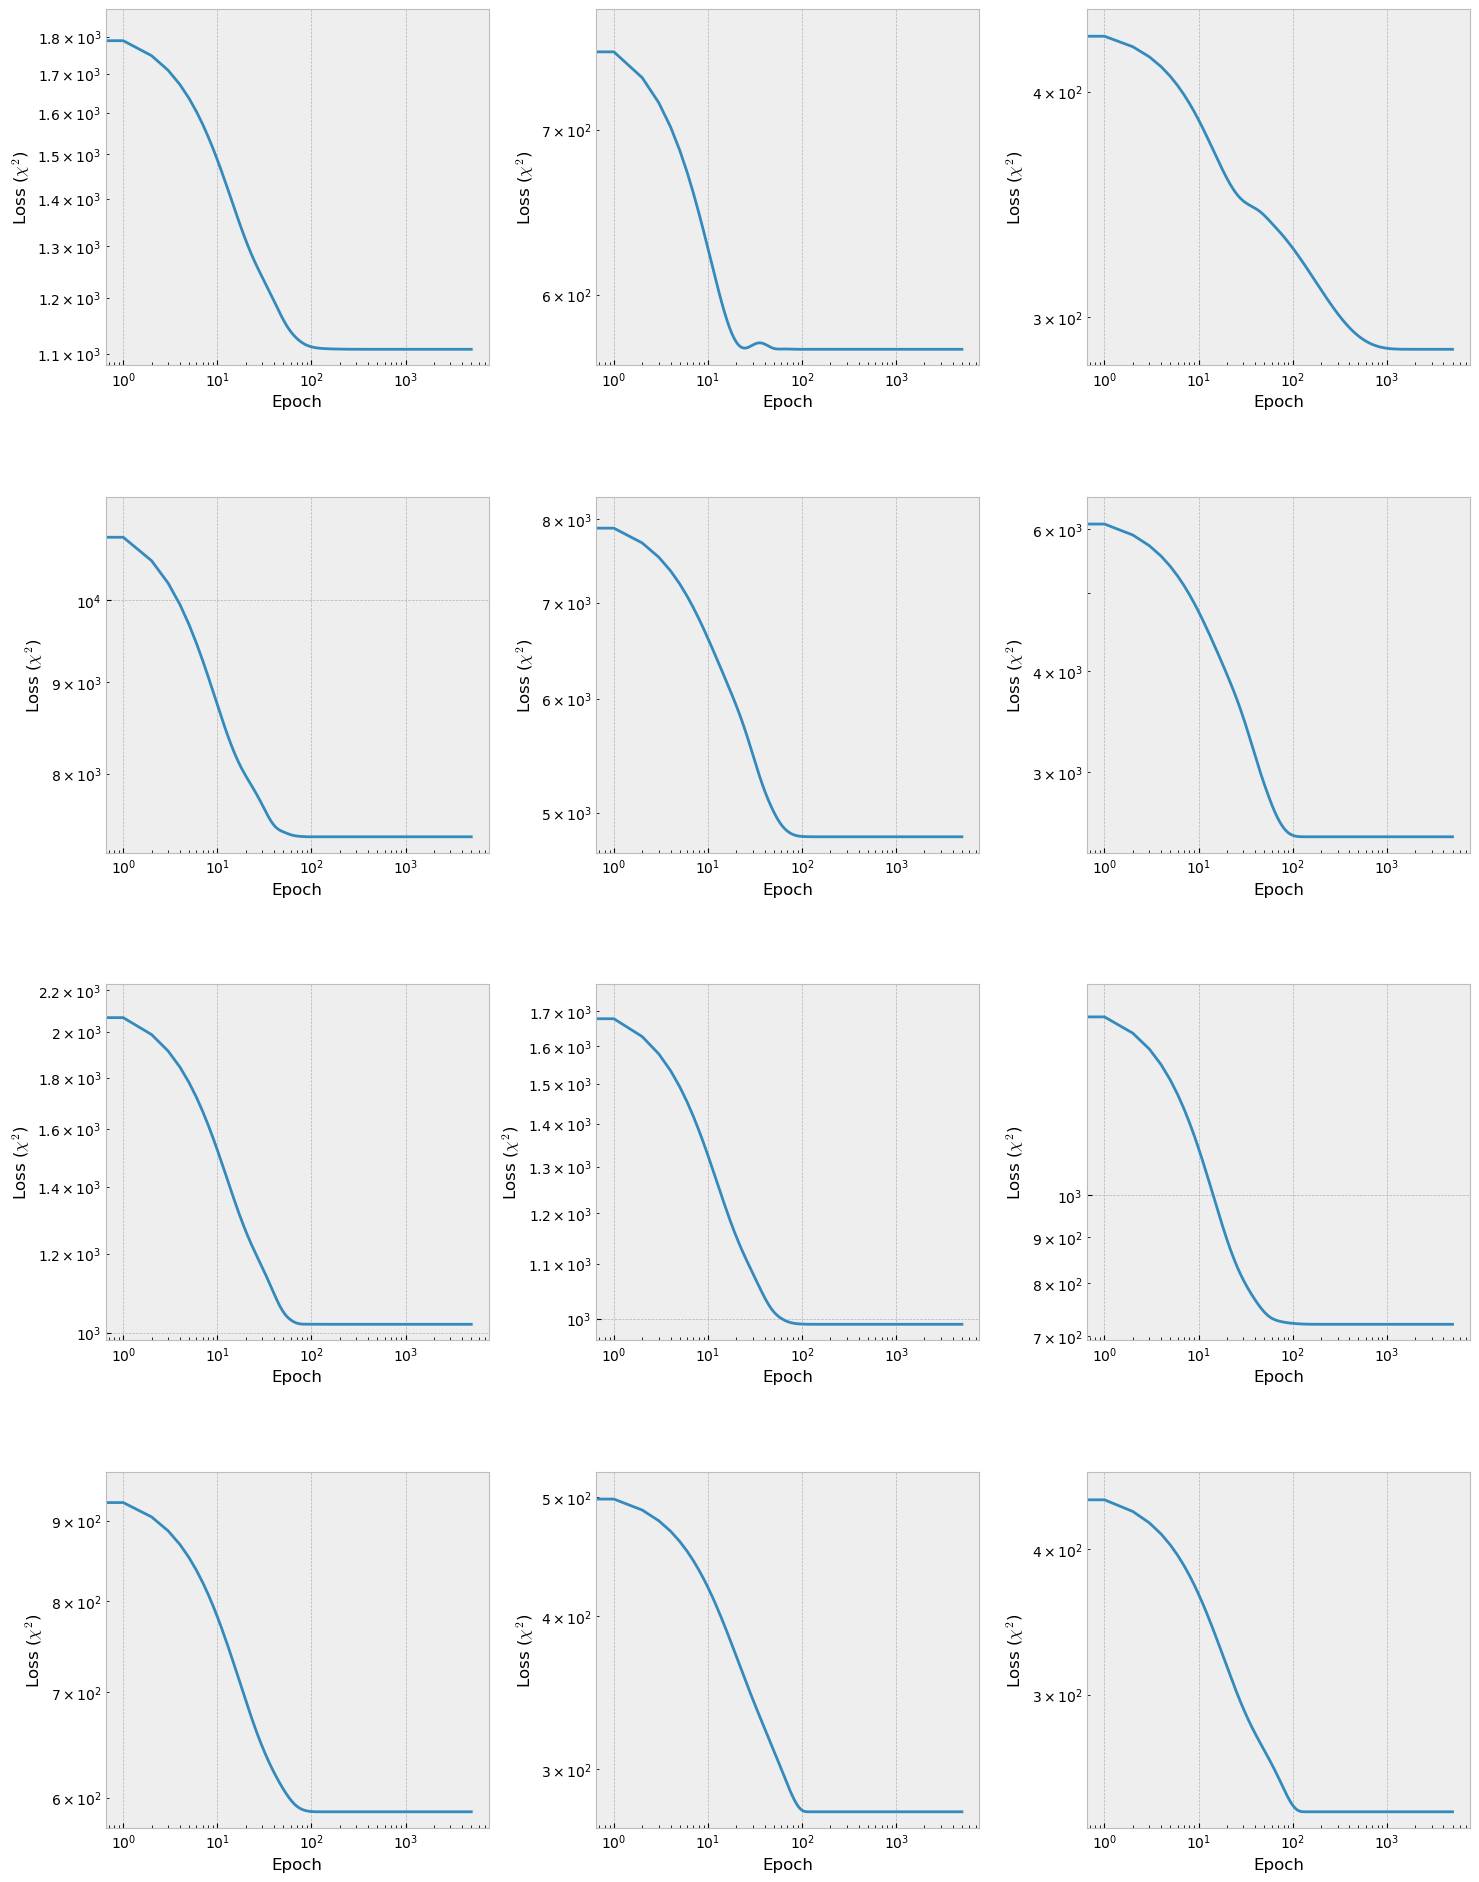

In [10]:
fig_pp, ax_pp = plot_losses(losses_all_pp, range_used)

0. Final result: lambda_theta =  2.5164060592651367  +-  nan
1. Final result: lambda_theta =  1.698270320892334  +-  nan
2. Final result: lambda_theta =  9.794107437133789  +-  nan
3. Final result: lambda_theta =  0.9375  +-  nan
4. Final result: lambda_theta =  1.87911856174469  +-  nan
5. Final result: lambda_theta =  0.9186930060386658  +-  nan
6. Final result: lambda_theta =  0.7954068183898926  +-  nan
7. Final result: lambda_theta =  1.2414144277572632  +-  nan
8. Final result: lambda_theta =  1.2331205606460571  +-  nan
9. Final result: lambda_theta =  0.7432345151901245  +-  nan
10. Final result: lambda_theta =  0.24733318388462067  +-  nan
11. Final result: lambda_theta =  0.214359849691391  +-  nan


Warning in <TCanvas::Constructor>: Deleting canvas with same name: can_cmp_0
Error in <TH2F::GetBinCenter>: Invalid method for a 2-d histogram - return a NaN
Error in <TH2F::GetBinCenter>: Invalid method for a 2-d histogram - return a NaN
Error in <TH2F::GetBinCenter>: Invalid method for a 2-d histogram - return a NaN
Error in <TH2F::GetBinCenter>: Invalid method for a 2-d histogram - return a NaN
Error in <TH2F::GetBinCenter>: Invalid method for a 2-d histogram - return a NaN
Error in <TH2F::GetBinCenter>: Invalid method for a 2-d histogram - return a NaN
Error in <TH2F::GetBinCenter>: Invalid method for a 2-d histogram - return a NaN
Error in <TH2F::GetBinCenter>: Invalid method for a 2-d histogram - return a NaN
Error in <TH2F::GetBinCenter>: Invalid method for a 2-d histogram - return a NaN
Error in <TH2F::GetBinCenter>: Invalid method for a 2-d histogram - return a NaN
Error in <TH2F::GetBinCenter>: Invalid method for a 2-d histogram - return a NaN
Error in <TH2F::GetBinCenter>: I

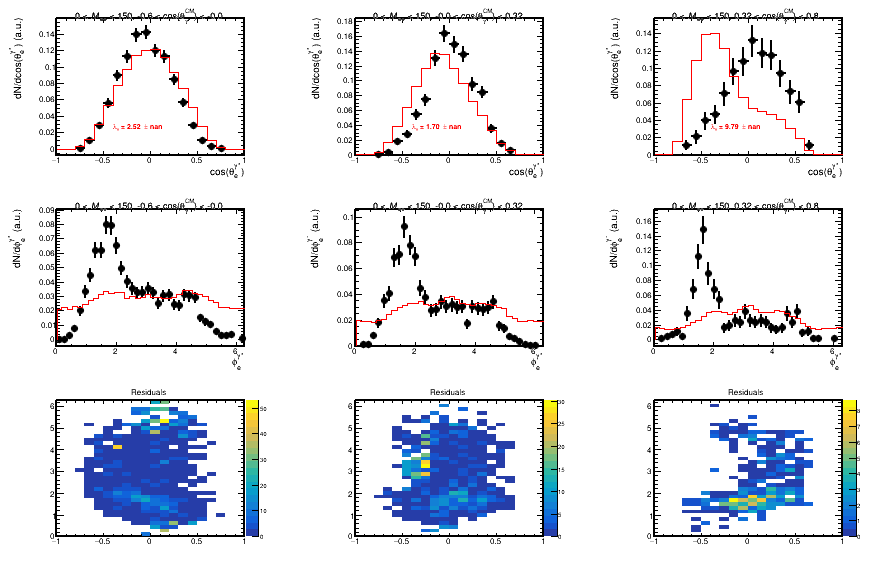

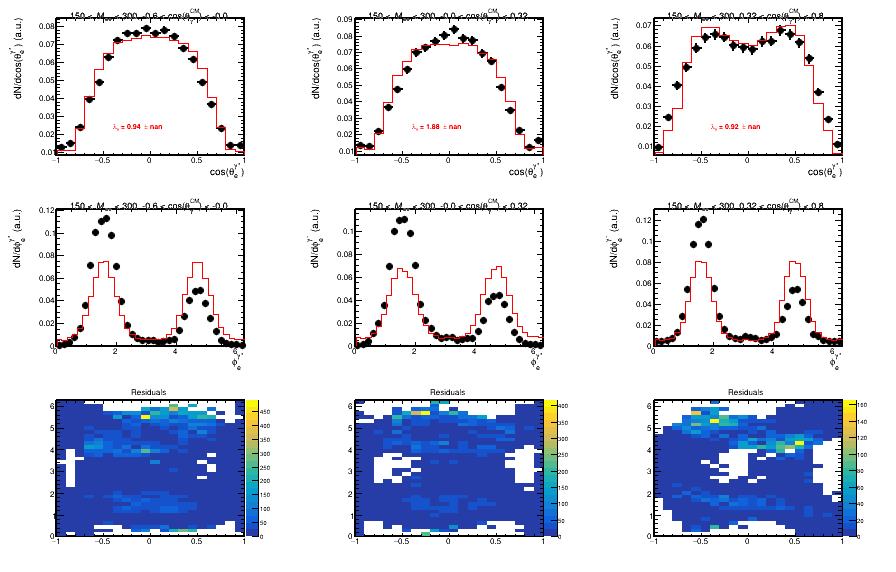

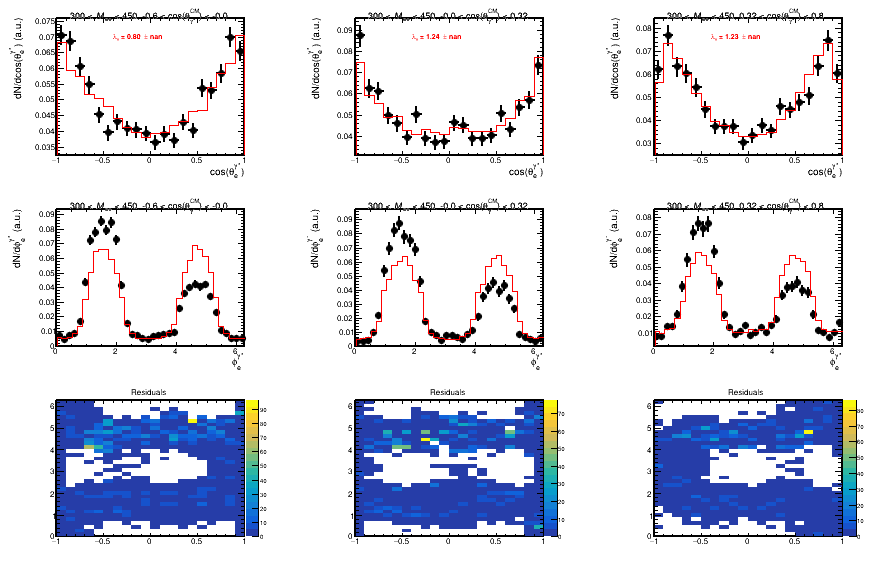

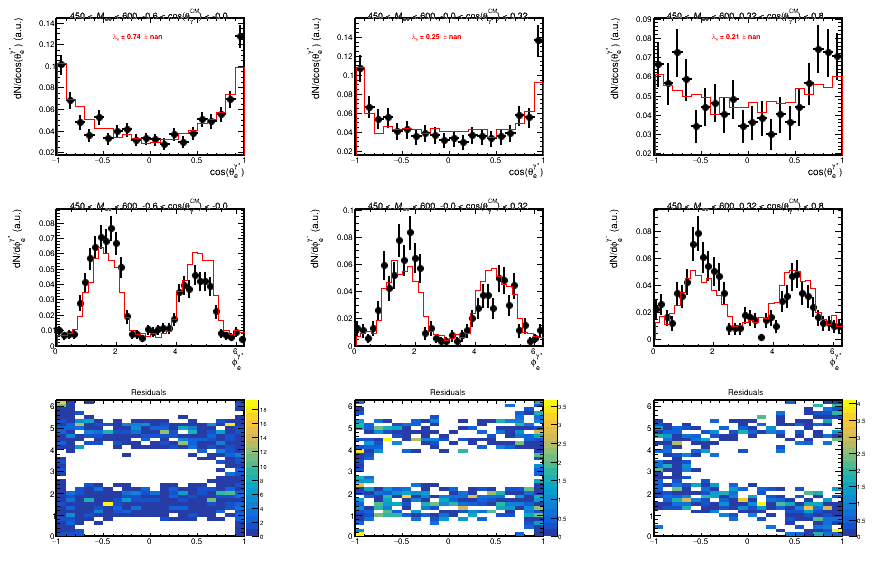

In [11]:
show_results("pp", DIR_NAME, range_used, parameters_all_pp, get_hist_maker_mc, bins, histsData_pp, analyse_3d)

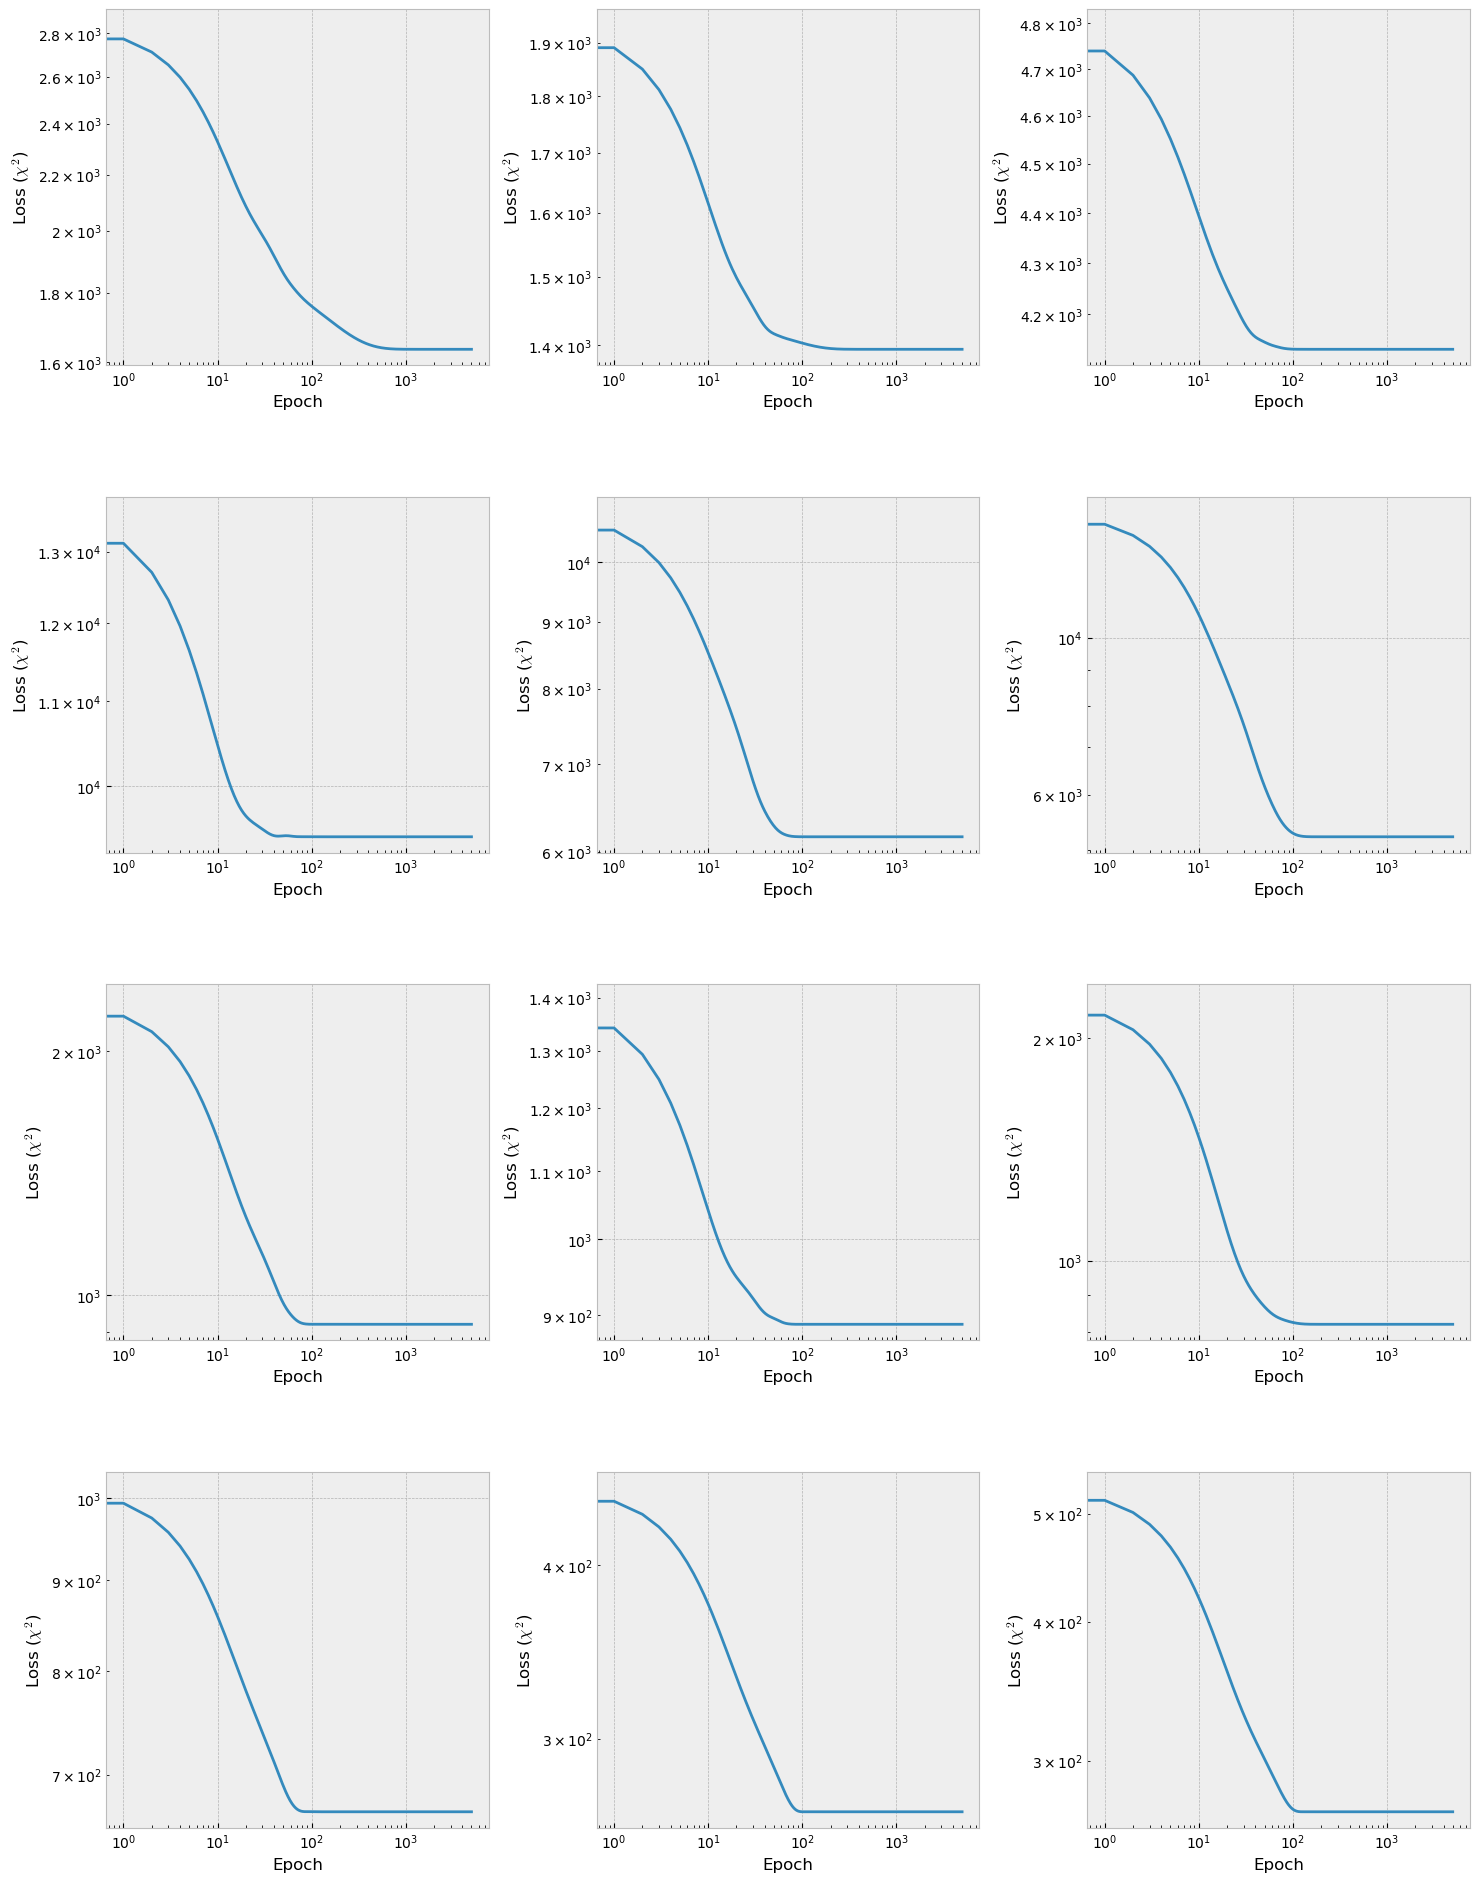

In [12]:
fig_nn, ax_nn = plot_losses(losses_all_nn, range_used)

0. Final result: lambda_theta =  6.469379425048828  +-  nan
1. Final result: lambda_theta =  2.928520441055298  +-  nan
2. Final result: lambda_theta =  0.659034013748169  +-  nan
3. Final result: lambda_theta =  1.5357986688613892  +-  nan
4. Final result: lambda_theta =  1.724538803100586  +-  nan
5. Final result: lambda_theta =  0.9134332537651062  +-  nan
6. Final result: lambda_theta =  0.8323017358779907  +-  nan
7. Final result: lambda_theta =  0.9776185154914856  +-  nan
8. Final result: lambda_theta =  1.0492360591888428  +-  nan
9. Final result: lambda_theta =  0.5111059546470642  +-  nan
10. Final result: lambda_theta =  0.3202051520347595  +-  nan
11. Final result: lambda_theta =  0.24557997286319733  +-  nan


Warning in <TCanvas::Constructor>: Deleting canvas with same name: can_cmp_0
Error in <TH2F::GetBinCenter>: Invalid method for a 2-d histogram - return a NaN
Error in <TH2F::GetBinCenter>: Invalid method for a 2-d histogram - return a NaN
Error in <TH2F::GetBinCenter>: Invalid method for a 2-d histogram - return a NaN
Error in <TH2F::GetBinCenter>: Invalid method for a 2-d histogram - return a NaN
Error in <TH2F::GetBinCenter>: Invalid method for a 2-d histogram - return a NaN
Error in <TH2F::GetBinCenter>: Invalid method for a 2-d histogram - return a NaN
Error in <TH2F::GetBinCenter>: Invalid method for a 2-d histogram - return a NaN
Error in <TH2F::GetBinCenter>: Invalid method for a 2-d histogram - return a NaN
Error in <TH2F::GetBinCenter>: Invalid method for a 2-d histogram - return a NaN
Error in <TH2F::GetBinCenter>: Invalid method for a 2-d histogram - return a NaN
Error in <TH2F::GetBinCenter>: Invalid method for a 2-d histogram - return a NaN
Error in <TH2F::GetBinCenter>: I

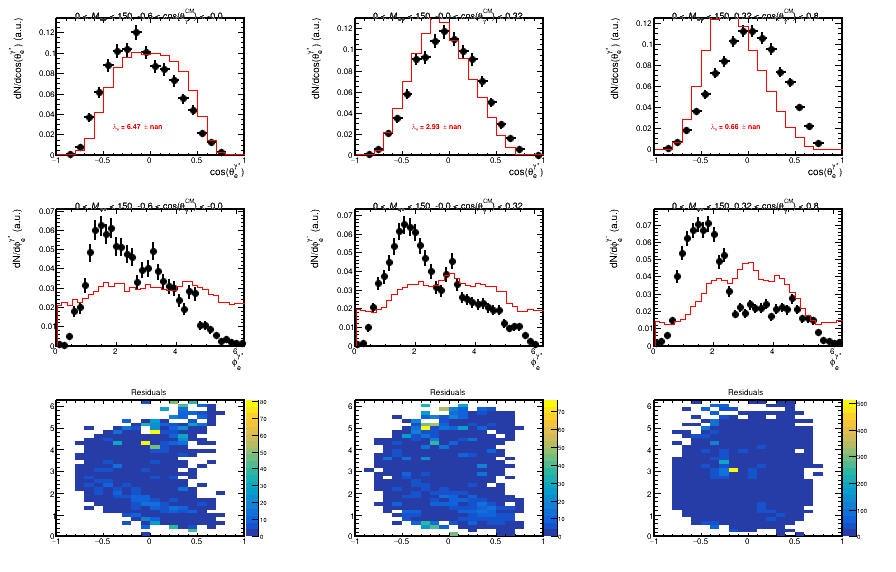

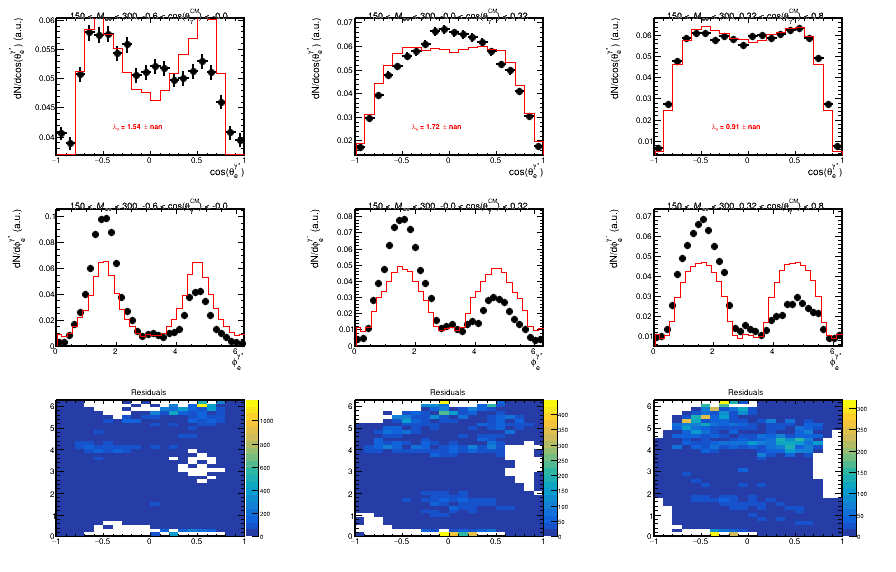

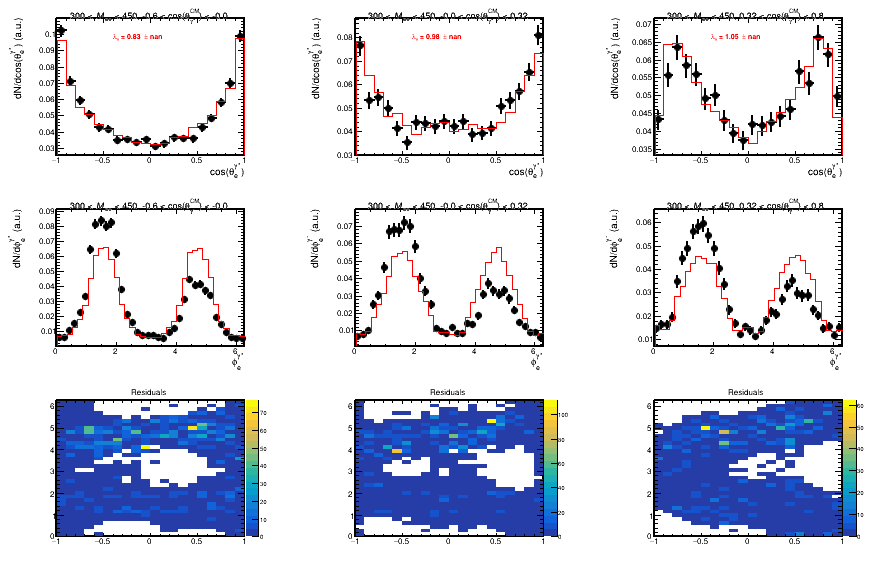

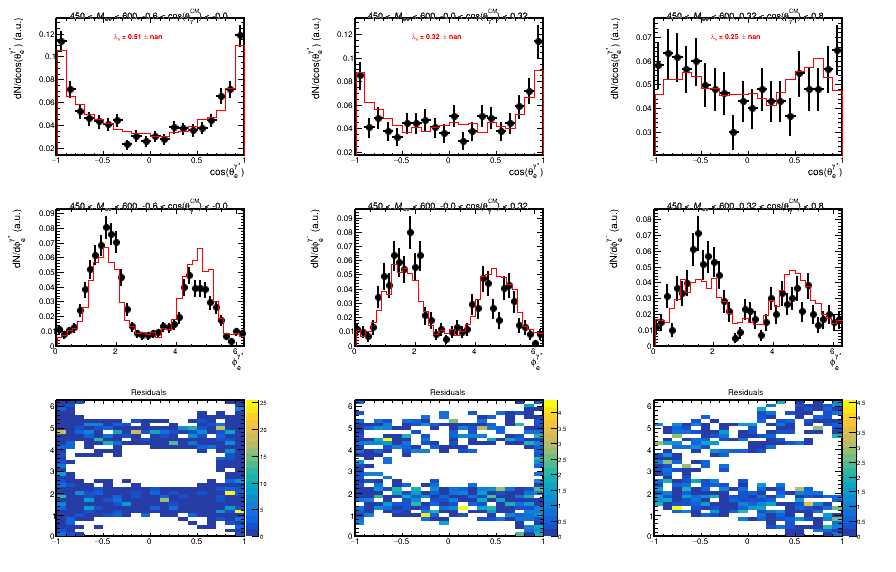

In [13]:
show_results("nn", DIR_NAME, range_used, parameters_all_nn, get_hist_maker_mc, bins, histsData_nn, analyse_3d)

In [14]:
if not analyse_3d:
    histsDataCorrs = []
    histsDatas = []
    histsModels = []
    hmodel_null = histMakerMC_rho_heli0.make_hists((0.0))
    hmodel_null_pp = histMakerMC_rho_heli0_pp.make_hists((0.0))
    hmodel_null_nn = histMakerMC_rho_heli0_nn.make_hists((0.0))
    hmodel_null_mix = histMakerMC_mix.make_hists((0.0))
    hmodel_null_pi0 = histMakerMC_pi0.make_hists((0.0))
    hmodel_null_heli1 = histMakerMC_rho_heli1.make_hists((0.0))

    pol2s = []
    histsAvg = []
    kfactors = []

    cc4 = TCanvas("cc4","cc4",900,1200)
    cc4.Divide(3,4)
    cc4.Draw()

    cck = TCanvas("cck","cck",900,1200)
    cck.Divide(3,4)

    csig = TCanvas("csig","csig",900,1200)
    csig.Divide(3,4)

    cacc = TCanvas("cacc","cacc",900,1200)
    cacc.Divide(3,4)

    for i, hist_np in enumerate(histsData_np[0]):
    
        if not isinstance(hist_np, list):

            hist_pp = histsData_pp[0][i]
            hist_nn = histsData_nn[0][i]
        
            if symmetrize_explicit:
                symmetrize(hist_np)
                symmetrize(hist_pp)
                symmetrize(hist_nn)
        
            histAvg = geom_avg1d(hist_pp, hist_nn, 0.2)
            histsAvg.append(histAvg)

        
            histCorr_np = hist_np.Clone(hist_np.GetName() + "_corr")
            histCorr_pp = hist_pp.Clone(hist_pp.GetName() + "_corr")
            histCorr_nn = hist_nn.Clone(hist_nn.GetName() + "_corr")
            histsDataCorrs.append(histCorr_np)
            histsDataCorrs.append(histCorr_pp)
            histsDataCorrs.append(histCorr_nn)
            histCorr_np.GetXaxis().SetTitle("cos(#theta_{e}^{#gamma*})")
        
            pad = cc4.cd(i+1)
            set_pad(pad)       
       
            hist_kfactor = histsData_np_mix[0][i]
            hist_pp_mix = histsData_pp_mix[0][i]
            hist_nn_mix = histsData_nn_mix[0][i]

            if symmetrize_explicit:
                symmetrize(hist_kfactor)
                symmetrize(hist_pp_mix)
                symmetrize(hist_nn_mix)

            histAvg_mix = geom_avg1d(hist_pp_mix, hist_nn_mix, 0.2)
            hist_kfactor.Divide(histAvg_mix)
            hist_kfactor.Scale(2)
            kfactors.append(hist_kfactor)

            pad = cck.cd(i+1)
            set_pad(pad)

            hist_kfactor.GetXaxis().SetTitle("cos(#theta_{e}^{#gamma*})")
        
            set_th1(hist_kfactor, histCorr_np.GetXaxis().GetTitle(), "#it{k}-factor", 
                   505, 20, 0.8, 1)
            hist_pp_mix.SetLineColor(2)
            hist_nn_mix.SetLineColor(4)
            hist_pp_mix.SetMarkerColor(2)
            hist_nn_mix.SetMarkerColor(4)
            hist_kfactor.Draw()
            hist_pp_mix.Draw("SAME")
            hist_nn_mix.Draw("SAME")
            hist_kfactor.SetMinimum(0)
             
            pad = cc4.cd(i+1)
            set_pad(pad)       
            
            histAvg_withK = histAvg.Clone(histAvg.GetName() + "_withK")
            histsAvg.append(histAvg_withK)
            histAvg_withK.Multiply(hist_kfactor)
            
            histAvg_withK.SetFillStyle(3004)
            histAvg_withK.SetFillColor(45)
            histAvg_withK.SetLineColor(45)
            histAvg.SetLineColor(6)
            hist_pp.SetLineColor(4)
            hist_nn.SetLineColor(2)
                    
            set_th1(hist_np, histCorr_np.GetXaxis().GetTitle(), f"dN/d{histCorr_np.GetXaxis().GetTitle()} (a.u.)", 
                   505, 20, 0.8, 1)
            hist_np.SetMinimum(0)
            hist_np.Draw()
            histAvg_withK.Draw("SAMEHIST")
            histAvg.Draw("SAMEHIST")
            hist_pp.Draw("SAMEHIST")
            hist_nn.Draw("SAMEHIST")
            
            pad = csig.cd(i+1)
            set_pad(pad)     
    
            hist_model_np = hmodel_null_mix[0][i]
            # TODO: make it consistent if we go the way of using mixing
            hist_model_pp = hmodel_null_mix[0][i]
            hist_model_nn = hmodel_null_mix[0][i]
            if not event_mixing:
                if i < 3:
                    hist_model_np = hmodel_null_pi0[0][i]
                    # TODO: make is consisnt if combinatorial background really matters for the pi0 region
                    hist_model_pp = hmodel_null_pi0[0][i]
                    hist_model_nn = hmodel_null_pi0[0][i]
                else:
                    hist_model_np = hmodel_null[0][i]
                    hist_model_pp = hmodel_null_pp[0][i]
                    hist_model_nn = hmodel_null_nn[0][i]
            if symmetrize_explicit:
                symmetrize(hist_model_np)
    
           # histCorr_np.Add(histAvg_withK,-1)
            histCorr_np.Divide(hist_model_np)
            histCorr_pp.Divide(hist_model_pp)
            histCorr_nn.Divide(hist_model_nn)
            
            histAvgCorr = geom_avg1d(histCorr_pp, histCorr_nn, 0.2)
            histsAvg.append(histAvgCorr)
            histAvgCorr_withK = histAvgCorr.Clone(histAvgCorr.GetName() + "_withK")
            histsAvg.append(histAvgCorr_withK)
            histAvgCorr_withK.Multiply(hist_kfactor)
        
            s2b = (hist_np.Integral() - histAvg_withK.Integral()) / histAvg_withK.Integral()
            s2b_corr = (histCorr_np.Integral() - histAvgCorr_withK.Integral()) / histAvgCorr_withK.Integral()
            histCorr_pp.Scale(s2b/s2b_corr)
            histCorr_nn.Scale(s2b/s2b_corr)
            histAvgCorr.Scale(s2b/s2b_corr)
            histAvgCorr_withK.Scale(s2b/s2b_corr)
        
            histAvgCorr_withK.SetFillStyle(3004)
            histAvgCorr_withK.SetFillColor(45)
            histAvgCorr_withK.SetLineColor(45)
            histAvgCorr.SetLineColor(6)
    
            #if symmetrize_explicit:    
                #symmetrize(histCorr_np)
    
            fit = TF1(f"fit_{i}", "[0]*(1+[1]*x*x)",-1.0,1.0)
            fit.SetParameters(1, 1)
            
            histCorr_np.Fit(fit,"Q")
            pol2s.append(fit)
        
            set_th1(histCorr_np, histCorr_np.GetXaxis().GetTitle(), f"dN/d{histCorr_np.GetXaxis().GetTitle()} (a.u.)", 
                   505, 20, 0.8, 1)
        
            histCorr_pp.SetLineColor(4)
            histCorr_nn.SetLineColor(2)
            histCorr_np.Draw()
            histCorr_pp.Draw("SAMEHIST")
            histCorr_nn.Draw("SAMEHIST")
            histAvgCorr.Draw("SAMEHIST")
            histAvgCorr_withK.Draw("SAMEHIST")
            if i < 3:
                # histCorr_np.GetYaxis().SetRangeUser(0,2.5)
                histCorr_np.GetYaxis().SetRangeUser(0,20)
            else:
                # histCorr_np.GetYaxis().SetRangeUser(0,1.25)    
                histCorr_np.GetYaxis().SetRangeUser(0,2)    
            histCorr_np.SetMinimum(0)
            
            caption = f"#lambda_{{#theta}} = {fit.GetParameter(1):.2f} #pm {fit.GetParError(1):.2f}"
            paveText = set_opt_text(caption, 0.25,0.76,0.675,0.88, 2, 0.04)
            paveTexts.append(paveText)
    
            pad = cacc.cd(i+1)
            set_pad(pad)
            
            hacc_heli0 = hmodel_null[0][i]
            hacc_heli1 = hmodel_null_heli1[0][i]
    
        else:
            print(hist_np)
    
    cc4.SaveAs(f"{DIR_NAME}/fit_classic.gif")
    cc4.SaveAs(f"{DIR_NAME}/fit_classic.pdf")
        


In [15]:
if not analyse_3d:
    cck.Draw()
    cck.SaveAs(f"{DIR_NAME}/kfactor.gif")
    
    csig.Draw()
    csig.SaveAs(f"{DIR_NAME}/signal.gif")

In [16]:
hmodelLowM_rho = histMakerMC_mix.make_hists(0.0) if event_mixing else histMakerMC_rho_heli0.make_hists(0.0)
hmodelLowM_rho[2][0].SetLineColor(8)
hmodelLowM_rho[1][0].SetLineColor(8)

hmodelLowM = histMakerMC_pi0.make_hists(0.0)

hmodelLowM[2][0].Scale(1.0/hmodelLowM[2][0].Integral())
hmodelLowM[1][0].Scale(1.0/hmodelLowM[1][0].Integral())
hmodelLowM_rho[2][0].Scale(1.0/hmodelLowM_rho[2][0].Integral())
hmodelLowM_rho[1][0].Scale(1.0/hmodelLowM_rho[1][0].Integral())

hmodelLowM[2][0].Add(hmodelLowM_rho[2][0], fraction)
hmodelLowM[1][0].Add(hmodelLowM_rho[1][0], fraction)

hmodelLowM[2][0].SetLineColor(2)
hmodelLowM[1][0].SetLineColor(2)
hmodelHigM = get_hist_maker_mc("np", 3).make_hists(0.0)
hmodelHigM[2][1].SetLineColor(2)
hmodelHigM[1][1].SetLineColor(2)

cc = TCanvas("cc","cc",800,800)
cc.Divide(2,2)
cc.Draw()

pad = cc.cd(1)
set_pad(pad)
dataScale = 1./histsData_np[2][0].Integral()
histsData_np[2][0].Scale(dataScale)
histsData_pp[2][0].Scale(dataScale)
histsData_nn[2][0].Scale(dataScale)
hmodelLowM[2][0].Scale(1./hmodelLowM[2][0].Integral())
hmodelLowM_rho[2][0].Scale(1./hmodelLowM_rho[2][0].Integral())
histsData_np[2][0].GetXaxis().SetTitle("cos(#theta^{CM}_{#gamma*})")
histsData_np[2][0].SetTitle("Masses below #pi^{0}")

set_th1(histsData_np[2][0], histsData_np[2][0].GetXaxis().GetTitle(), 
       f"dN/d{histsData_np[2][0].GetXaxis().GetTitle()} (a.u.)", 505, 20, 0.8, 1)
histsData_np[2][0].Draw()
#histsData_pp[2][0].Draw("SAME")
#histsData_nn[2][0].Draw("SAME")
hmodelLowM[2][0].Draw("SAMEHIST")
hmodelLowM_rho[2][0].Draw("SAMEHIST")

pad = cc.cd(2)
pad.SetLogy()
set_pad(pad)
histsData_np[1][0].Scale(1./histsData_np[1][0].Integral())
hmodelLowM[1][0].Scale(1./hmodelLowM[1][0].Integral())
hmodelLowM_rho[1][0].Scale(1./hmodelLowM_rho[1][0].Integral())
histsData_np[1][0].SetTitle("Masses below #pi^{0}")
histsData_np[1][0].GetXaxis().SetTitle("#it{M}_{ee} (GeV/#it{c}^{2})")

set_th1(histsData_np[1][0], histsData_np[1][0].GetXaxis().GetTitle(), 
       f"dN/d{histsData_np[1][0].GetXaxis().GetTitle()} (a.u.)", 505, 20, 0.8, 1)
histsData_np[1][0].Draw("HIST")
hmodelLowM[1][0].Draw("SAMEHIST")
hmodelLowM_rho[1][0].Draw("SAMEHIST")

legend = TLegend(0.7, 0.7, 0.9, 0.9)
legend.AddEntry(histsData_np[1][0], "exp", "pl")
legend.AddEntry(hmodelLowM[1][0], f"#pi^{{0}} + {fraction}#rho", "l")
legend.AddEntry(hmodelLowM_rho[1][0], "#rho", "l")
legend.Draw()

pad = cc.cd(3)
set_pad(pad)
histsData_np[2][1].Scale(1./histsData_np[2][1].Integral())
hmodelHigM[2][1].Scale(1./hmodelHigM[2][1].Integral())
hmodelLowM_rho[2][1].Scale(1./hmodelLowM_rho[2][1].Integral())
histsData_np[2][1].GetXaxis().SetTitle("cos(#theta^{CM}_{#gamma*})")
histsData_np[2][1].SetTitle("Masses above #pi^{0}")

set_th1(histsData_np[2][1], histsData_np[2][1].GetXaxis().GetTitle(), 
       f"dN/d{histsData_np[2][1].GetXaxis().GetTitle()} (a.u.)", 505, 20, 0.8, 1)
histsData_np[2][1].Draw()
hmodelHigM[2][1].Draw("SAMEHIST")
#hmodelLowM_rho[2][1].Draw("SAMEHIST")

pad = cc.cd(4)
pad.SetLogy()
set_pad(pad)
histsData_np[1][1].Scale(1./histsData_np[1][1].Integral())
hmodelHigM[1][1].Scale(1./hmodelHigM[1][1].Integral())
hmodelLowM_rho[1][1].Scale(1./hmodelLowM_rho[1][1].Integral())
histsData_np[1][1].GetXaxis().SetTitle("#it{M}_{ee} (GeV/#it{c}^{2})")
histsData_np[1][1].SetTitle("Masses above #pi^{0}")

set_th1(histsData_np[1][1], histsData_np[1][1].GetXaxis().GetTitle(), 
       f"dN/d{histsData_np[1][1].GetXaxis().GetTitle()} (a.u.)", 505, 20, 0.8, 1)
histsData_np[1][1].Draw()
hmodelHigM[1][1].Draw("SAMEHIST")
#hmodelLowM_rho[1][1].Draw("SAMEHIST")

cc.SaveAs(f"{DIR_NAME}/cmp_mass_z.gif")

IndexError: list index out of range

In [ ]:
cacc.Draw()
cacc.SaveAs(f"{DIR_NAME}/cacc.gif")
